Chargement du dataset ML final...
Dataset chargé. Shape: (836126, 29)
Définition des features pour le Modèle B (Financier uniquement)...
Features (X) sélectionnées: ['ratio_rentabilite_nette', 'ratio_endettement', 'ratio_marge_brute', 'ratio_capitaux_propres', 'ratio_tresorerie', 'ratio_resultat_financier', 'ratio_resultat_exceptionnel']
Target (y) sélectionnée: is_failed_in_3y
Ratio de déséquilibre (scale_pos_weight): 69.54
Création de la pipeline (Preprocessor + XGBoost)...
Entraînement du Modèle B (Financier)...


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:28:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Évaluation du Modèle B...
---
--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---
Score ROC-AUC (Financier): 0.5091
---
Rapport de Classification (Financier):
               precision    recall  f1-score   support

Survivant (0)       1.00      0.02      0.04    164855
 Faillite (1)       0.01      1.00      0.03      2371

     accuracy                           0.03    167226
    macro avg       0.51      0.51      0.03    167226
 weighted avg       0.98      0.03      0.04    167226

---
Matrice de Confusion (Financier):


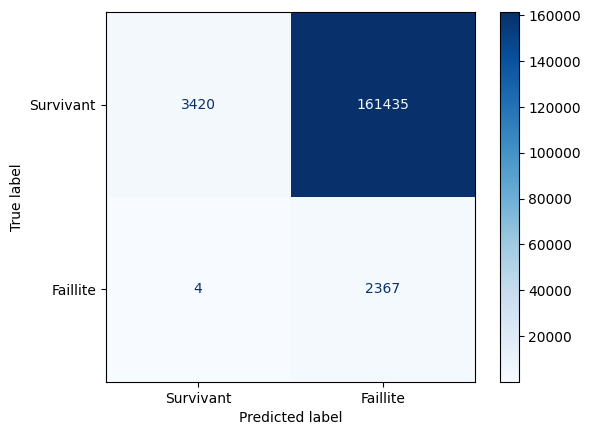

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# ▼▼▼ ON CHANGE LE PREPROCESSOR ▼▼▼
from sklearn.preprocessing import StandardScaler 
# ▲▲▲ ON CHANGE LE PREPROCESSOR ▲▲▲
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- 1. CHARGER LE DATASET ML FINAL ---
print("Chargement du dataset ML final...")
try:
    df_final_ml = pl.read_parquet("../Data/processed/dataset_ml.parquet")
    print(f"Dataset chargé. Shape: {df_final_ml.shape}")
except Exception as e:
    print("ERREUR: Fichier 'dataset_ml.parquet' non trouvé.")
    print(e)

# --- 2. DÉFINITION DES FEATURES (ITÉRATION 2) ---
print("Définition des features pour le Modèle B (Financier uniquement)...")

# ▼▼▼ ON CHANGE LES FEATURES ▼▼▼
# C'est notre 2ème "modification de features" : on ne prend QUE les ratios INPI
FINANCIAL_FEATURES = [
    "ratio_rentabilite_nette", 
    "ratio_endettement", 
    "ratio_marge_brute", 
    "ratio_capitaux_propres",
    "ratio_tresorerie",
    "ratio_resultat_financier",
    "ratio_resultat_exceptionnel"
    # On pourrait aussi ajouter les 11 codes 'bruts' (HN_ResultatNet, etc.)
    # mais commençons par les 7 ratios "experts"
]
# ▲▲▲ ON CHANGE LES FEATURES ▲▲▲

TARGET = "is_failed_in_3y"

# On convertit en Pandas pour Scikit-Learn
X = df_final_ml.select(FINANCIAL_FEATURES).to_pandas()
y = df_final_ml.select(TARGET).to_pandas().squeeze()

print(f"Features (X) sélectionnées: {X.columns.to_list()}")
print(f"Target (y) sélectionnée: {y.name}")

# --- 3. GESTION DU DÉSÉQUILIBRE ---
# (Rien ne change ici)
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
print(f"Ratio de déséquilibre (scale_pos_weight): {scale_pos_weight:.2f}")

# --- 4. PRÉPARATION (Preprocessing) ---
# ▼▼▼ ON CHANGE LE PREPROCESSING ▼▼▼
# Nos features sont toutes numériques. On doit les 'Scaler'.
numerical_features = FINANCIAL_FEATURES
numerical_transformer = StandardScaler() # On utilise StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features) # On applique le scaler
    ],
    remainder="passthrough"
)
# ▲▲▲ ON CHANGE LE PREPROCESSING ▲▲▲

# --- 5. SPLIT (Train / Test) ---
# (Rien ne change ici)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. CRÉATION DE LA PIPELINE DE MODÉLISATION ---
print("Création de la pipeline (Preprocessor + XGBoost)...")
# (Rien ne change ici)
model_B = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight=scale_pos_weight, 
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ))
])

# --- 7. ENTRAÎNEMENT (Itération 2) ---
print("Entraînement du Modèle B (Financier)...")
model_B.fit(X_train, y_train)

# --- 8. ÉVALUATION (Le Score "Moteur") ---
print("Évaluation du Modèle B...")
y_pred = model_B.predict(X_test)
y_pred_proba = model_B.predict_proba(X_test)[:, 1]

# Scores
auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred, target_names=["Survivant (0)", "Faillite (1)"])

# ▼▼▼ ON CHANGE LES TITRES DE SORTIE ▼▼▼
print("---")
print("--- RÉSULTATS DU MODÈLE B (ITÉRATION 'FINANCIÈRE') ---")
print(f"Score ROC-AUC (Financier): {auc_score:.4f}")
print("---")
print("Rapport de Classification (Financier):")
print(report)
print("---")

# Plot Matrice de Confusion
print("Matrice de Confusion (Financier):")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survivant", "Faillite"])
disp.plot(cmap=plt.cm.Blues)
plt.show()
# ▲▲▲ ON CHANGE LES TITRES DE SORTIE ▲▲▲